In [1]:
# importing required libraries
import torch.nn as nn
import torch
import torch.nn.functional as F
import math,copy,re
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import torchtext
import matplotlib.pyplot as plt
warnings.simplefilter("ignore")
print(torch.__version__)

1.13.1+cu117


In [2]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 2070 SUPER'

# Components

## Create Word Embeddings

First of all we need to convert each word in the input sequence to an embedding vector. Embedding vectors will create a more semantic representation of each word.

Suppoese each embedding vector is of 512 dimension and suppose our vocab size is 100, then our embedding matrix will be of size 100x512. These marix will be learned on training and during inference each word will be mapped to corresponding 512 d vector. Suppose we have batch size of 32 and sequence length of 10(10 words). The the output will be 32x10x512. (Batch, Step, Feature)

In [13]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        '''
        Parameters:
            vocab_size: size of the vocabulary 
            embed_dim: dimension of embeddings
        '''
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
    
    def forward(self, x):
        '''
        Parameters:
            x: input vector
        Returns:
            embedding vector
        '''
        return self.embed(x)


## Positional Encoding

After creating Word Embeddings it is time to create Positional Encodings. In order for the Transformer to understand the sentence. It needs 2 things: 
- What words mean?
- What are their positions in the sentence.

There are 2 formula for crateing Positional Encodings. A 'cosine' function for 'odd' timesteps and a 'sine' function' for 'even' timesteps. 
- 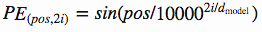
- image.png

  * pos -> word position in sentence
  * i -> position along embedding vector dimension

Positional Encoding will generate a similar matrix as Word Embedding. Matrix shape will be -> (sequence_length x embedding dimesion). At the end we will add these 2 matrix together. So for each word we will have an embedding vector with shape (1x512) and corresponding postional encoding vector with shape (1x512).

if we include the batch size and sequence lengts to this logic than the shapes will be (batch_size x sequence_length x embed_dim(feature))

see image:
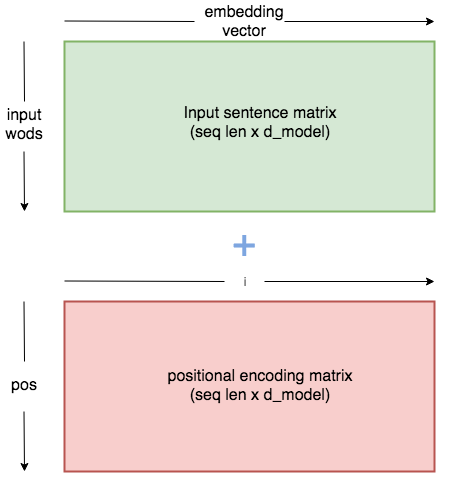

In [14]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_seq_len, embed_dim):
        '''
        Class to calculate Positional Encoding
        Parameters:
            max_seq_len: maximum sequence length to expect
            emded_dim: dimension of word embeding
        '''
        super().__init__()
        self.embed_dim = embed_dim
        
        # create a null matrix
        pos_enc = torch.zeros(max_seq_len, self.embed_dim)

        # apply the sine and cosine functions from 'attention is all you need' paper
        for pos in range(max_seq_len):
            for i in range(0, self.embed_dim, 2):
                pos_enc[pos, i] = math.sin(pos / 10000**((2*i)/self.embed_dim))
                pos_enc[pos, i+1] = math.cos(pos / 10000**((2*(i+1))/self.embed_dim))

        pos_enc = pos_enc.unsqueeze(0)

        # register buffer in Pytorch ->
        # If you have parameters in your model, which should be saved and restored in the state_dict,
        # but not trained by the optimizer, you should register them as buffers.
        self.register_buffer('pos_enc', pos_enc)

    def forward(self, x):
        """
        Args:
            x: input vector
        Returns:
            x: output
        """
      
        # make embeddings relatively larger
        #x = x * math.sqrt(self.embed_dim)
        #add constant to embedding
        #seq_len = x.size(1)
        #x = x + torch.autograd.Variable(self.pos_enc[:,:seq_len], requires_grad=False)
        x = x + self.pos_enc[:, :x.size(1)]
        return x


## Multi Head Attention

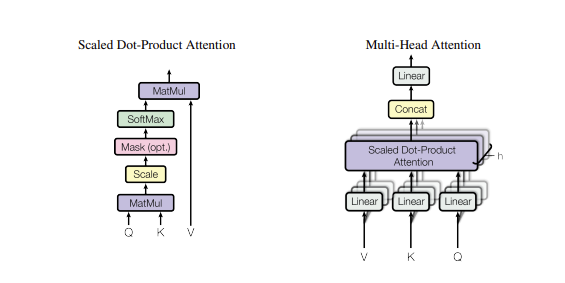

In [15]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim=512, heads=8):
        '''
        Parameters:
            embed_dim: dimension of the embedding vector output
            heads: number of self attention heads
        '''
        super().__init__()

        self.embed_dim = embed_dim
        self.n_heads = heads
        self.single_head_dim = int(self.embed_dim/self.n_heads)

        self.query_matrix = nn.Linear(self.single_head_dim, self.single_head_dim, bias=False)
        self.key_matrix = nn.Linear(self.single_head_dim, self.single_head_dim, bias=False)
        self.value_matrix = nn.Linear(self.single_head_dim, self.single_head_dim, bias=False)

        self.out = nn.Linear(self.n_heads*self.single_head_dim, self.embed_dim)
    
    def forward(self, key, query, value, mask=None):
        batch_size = key.size(0)
        seq_len = key.size(1)
        query_seq_len = query.size(1)

        key = key.view(batch_size, seq_len, self.n_heads, self.single_head_dim) # 32x10x8x64
        query = query.view(batch_size, query_seq_len, self.n_heads, self.single_head_dim) # 32x10x8x64
        value = value.view(batch_size, seq_len, self.n_heads, self.single_head_dim) # 32x10x8x64

        product = torch.einsum('bqhd, bkhd -> bhqk', [query, key])


        # fill those positions of product matrix as (-1e20) where mask positions are 0
        if mask is not None:
             product = product.masked_fill(mask == 0, float("-1e20"))

        att = torch.softmax(product/self.embed_dim**(1/2), dim=3)
        out = torch.einsum('bhqk, bkhd -> bqhd', [att, value]).reshape(batch_size, query_seq_len, self.n_heads*self.single_head_dim) 
        out = self.out(out)

        return out

## Encoder

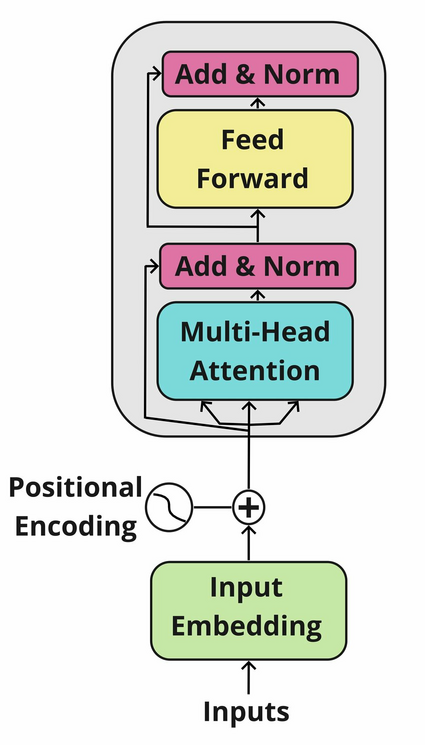

In [16]:
class EncoderBlock(nn.Module):
    def __init__(self, embed_dim, expension_factor=4, n_heads=8):
        '''
        Parameters:
            embed_dim: dimension of the embedding vector
            expension_factor: factor which determines the dimension of the linear layer
            n_heads: number of attention heads.
        '''
        super().__init__()

        self.attention = MultiHeadAttention(embed_dim, n_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_dim, expension_factor*embed_dim),
            nn.ReLU(),
            nn.Linear(expension_factor*embed_dim, embed_dim)
        )

        self.dropout1 = nn.Dropout(.2)
        self.dropout2 = nn.Dropout(.2)

    def forward(self, key, query, value):
        attention = self.attention(key, query, value) # 32x10x512

        norm1_out = self.dropout1(self.norm1(attention + query)) # 32x10x512
        ff_out = self.feed_forward(norm1_out)  # 32x10x512 -> #32x10x2048 -> 32x10x512

        norm2_out = self.dropout2(self.norm2(ff_out + norm1_out)) # 32x10x512

        return norm2_out
        

class TransformerEncoder(nn.Module):
    def __init__(self, seq_len, vocab_size, embed_dim, num_layers=2, expension_factor=4, n_heads=8):
        '''
        Parameters:
            seq_len: length of the sequence
            vocab_size: size of the vocabulary ot the data
            embed_dim: dimension of embedding
            num_layers: number of encoder layers
            expension_factor: factor which determines the linear layers in feed forward step
            n_heads: number of heads for multi head attention
        Returns:
            out: output of the encoder.
        '''
        super().__init__()

        self.embedding_layer = Embedding(vocab_size, embed_dim)
        self.pos_encoding = PositionalEncoding(seq_len, embed_dim)
        self.layers = nn.ModuleList([EncoderBlock(embed_dim, expension_factor, n_heads) for i in range(num_layers)])
    
    def forward(self, x):
        embed_out = self.embedding_layer(x)
        out = self.pos_encoding(embed_out)

        for layer in self.layers:
            out = layer(out, out, out)
        
        return out 


## Decoder
 
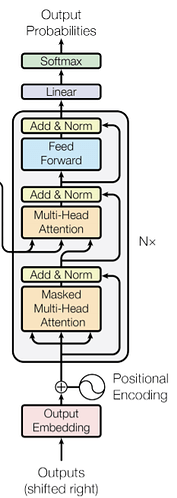

## only query input comes from decoder, key and value comes from encoder

In [17]:
class DecoderBlock(nn.Module):
    def __init__(self, embed_dim, expension_factor=4, n_heads=8):
        super().__init__()

        self.attention = MultiHeadAttention(embed_dim, n_heads) 
        self.norm = nn.LayerNorm(embed_dim)
        self.do = nn.Dropout(.2)
        self.encoder_block = EncoderBlock(embed_dim, expension_factor, n_heads)

    def forward(self, key, x, value, mask):
        att = self.attention(x, x, x, mask)
        query = self.do(self.norm(att + x))
        out = self.encoder_block(key, query, value)
        return out

class TransformerDecoder(nn.Module):
    def __init__(self, target_vocab_size, embed_dim, seq_len, num_layers=2, expension_factor=4, n_heads=8):
        super().__init__()

        self.word_embedding = Embedding(target_vocab_size, embed_dim)
        self.pos_enc = PositionalEncoding(seq_len, embed_dim)

        self.layers = nn.ModuleList([
            DecoderBlock(embed_dim, expension_factor=4, n_heads=8) for _ in range(num_layers)
        ])

        self.fully_connected = nn.Linear(embed_dim, target_vocab_size)
        self.do = nn.Dropout(.2)

    def forward(self, x, enc_out, mask):
        x = self.word_embedding(x)
        x = self.pos_enc(x)
        x = self.do(x)

        for layer in self.layers:
            x = layer(enc_out, x, enc_out, mask)
        
        out = F.softmax(self.fully_connected(x))
        return out


## Put it all togetger: Transformer

In [18]:
class Transformer(nn.Module):
    def __init__(self, embed_dim, src_vocab_size, tgt_vocab_size, seq_len, num_layers=2, expansion_factor=4, n_heads=8):
        super().__init__()
        self.tgt_vocab_size = tgt_vocab_size
        self.encoder = TransformerEncoder(seq_len, src_vocab_size, embed_dim, num_layers, expansion_factor, n_heads)
        self.decoder = TransformerDecoder(tgt_vocab_size, embed_dim, seq_len, num_layers, expansion_factor, n_heads)
    
    def make_tgt_mask(self, tgt):
        bs, tgt_len = tgt.shape
        tgt_mask = torch.tril(torch.ones(tgt_len, tgt_len)).expand(bs, 1, tgt_len, tgt_len)
        return tgt_mask
    
    def decode(self, src, tgt):
        tgt_mask = self.make_tgt_mask(tgt)
        enc_out = self.encoder(src)
        out_labels = []
        batch_size, seq_len = src.shape[0], src.shape[1]
        out = tgt

        for i in range(seq_len):
            out = self.decoder(out, enc_out, tgt_mask)
            out = out[:, -1, :]
     
            out = out.argmax(-1)
            out_labels.append(out.item())
            out = torch.unsqueeze(out, axis=0)
        
        return out_labels
    
    def forward(self, src, tgt):
        tgt_mask = self.make_tgt_mask(tgt)
        enc_out = self.encoder(src)

        out = self.decoder(tgt, enc_out, tgt_mask)
        return out